In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
sns.set()

## Read Data

In [2]:
data_file = Path.cwd().parent / 'data' / 'kaggle' / 'data.xlsx'

# Match data
df_match = pd.read_excel(data_file, sheet_name='Match', index_col='Candidate_match')
df_match.columns = (
    'match_id', 
    'status', 
    'cv_received',
    'cv_validated',
    'cv_approved'
)
df_match.index.names = ['candidate_match']

# Candidate data
df_candidate = pd.read_excel(data_file, sheet_name='Candidate', index_col='CV_ID')
df_candidate.columns = ('experience', 'french_level')
df_candidate.index.names = ['cv_id']

In [3]:
df_candidate.sample(1)

,experience,french_level
cv_id,,
6460,NaN,NaN


In [4]:
df_match.status.unique()

array(['Rejected', 'CV refused', 'Candidate refused',
       'A03 - Offer declined', 'D01 – Resignation', 'A05 - Onboarding',
       'Candidate dropped out', 'CV dropped out', 'T01- Terminated',
       'A03 - Process Cancelled', 'Dropped out', 'Approved',
       'CV sent to France', 'Matched', 'Candidate validated',
       'A01 - Offer Preparation Started',
       'A04b – Hiring Started / Contract signed', 'A03 - Offer accepted',
       'CV approved', 'A04 - Hiring Request Started', 'Sent to Client'],
      dtype=object)

## EDA

In [5]:
status_go_match = [
    'A01 - Offer Preparation Started',
    'A02 - Offer Sent to Candidate',
    'A03 - Offer accepted',
    'A03 - Offer declined',
    'A03 - Process Cancelled',
    'A04 - Hiring Request Started',
    'A04a – Hiring Started / Collecting signatures',
    'A04b – Hiring Started / Contract signed',
    'A05 - Onboarding',
    'A06 - Offboarding',
    'B01 - Subcontracting Started',
    'B02 - Subcontracting Signed',
    'D01 – Resignation',
    'T01- Terminated',
    'Candidate validated'
]
df_match_go = df_match[df_match.status.isin(status_go_match)]
no_go_pct = (1 - df_match_go.shape[0] / df_match.shape[0]) * 100
print("Input data has only {}/{} ({}%) accepted candidates.".format(
    df_match_go.shape[0],
    df_match.shape[0],
    round(df_match_go.shape[0] / df_match.shape[0] * 100, 2)
))
print("Since the data is so skewed, we will not use accuracy as a performance measure")

Input data has only 347/2255 (15.39%) accepted candidates.
Since the data is so skewed, we will not use accuracy as a performance measure


## Feature Engineering
### Combine `candidate` and `match` dataframes

In [6]:
shell = pd.DataFrame(index=df_candidate.index)
shell['french_level'] = df_candidate.french_level[df_candidate.french_level.notnull()]
shell['experience'] = df_candidate.experience[df_candidate.experience.notnull()]

In [7]:
df = pd.concat([df_match, shell], axis=1, join='inner')
df.set_index('match_id', inplace=True)

In [8]:
df.sample(1)

,status,cv_received,cv_validated,cv_approved,french_level,experience
match_id,,,,,,
13228,Rejected,NaT,NaT,NaT,A1,[8+]


### Add Computed features

In [9]:
df['response_time'] = (df['cv_validated'] - df['cv_received']).dt.days
df['decision_time'] = (df['cv_approved'] - df['cv_validated']).dt.days

In [10]:
df.sample(1)

,status,cv_received,cv_validated,cv_approved,french_level,experience,response_time,decision_time
match_id,,,,,,,,
11052,Candidate dropped out,2017-07-15,2017-07-27,2018-04-03,A1,[5-8],12.0,250.0


### Add Mapped Status 
Boolean _Go_ -> 1 or _No Go_ -> 0

In [11]:
status_map = {
    'Rejected': 0,
    'CV refused': 0,
    'A02 - Offer Sent to Candidate': 1,
    'Candidate refused': 0,
    'A03 - Offer declined': 1,
    'D01 – Resignation': 1,
    'A05 - Onboarding': 1,
    'Candidate dropped out': 0,
    'CV dropped out': 0,
    'T01- Terminated': 1,
    'A03 - Process Cancelled': 1,
    'Dropped out': 0,
    'Approved': 0,
    'CV sent to France': 0,
    'Matched': 0,
    'Candidate validated': 1,
    'A01 - Offer Preparation Started': 1,
    'A04b – Hiring Started / Contract signed': 1,
    'A03 - Offer accepted': 1,
    'CV approved': 0,
    'A04 - Hiring Request Started': 1,
    'Sent to Client': 0
}
df['status_mapped'] = df.status.map(status_map).astype(int)

In [12]:
df.sample(1)

,status,cv_received,cv_validated,cv_approved,french_level,experience,response_time,decision_time,status_mapped
match_id,,,,,,,,,
10534,Candidate refused,2017-03-14,2017-03-21,2017-03-27,B1,[8+],7.0,6.0,0


### Remove Outliers

In [13]:
respose_time_outliers = df.index[df['response_time'] < 0].to_list()
decision_time_outliers = df.index[df['decision_time'] < 0].to_list()

In [14]:
for i, item in enumerate(respose_time_outliers):
    df.loc[item, 'response_time'] = df['response_time'].mean()
for i, item in enumerate(decision_time_outliers):
    df.loc[item, 'decision_time'] = df['decision_time'].mean()

### Augmenting

In [15]:
df['french_level'] = df['french_level'].fillna('0')
df = df[df['experience'].notnull()]
df.skew() # <- TODO address high skew

response_time    5.161424
decision_time    3.789535
status_mapped    0.187861
dtype: float64

In [16]:
ct = pd.crosstab(df['response_time'], df['status_mapped'])
ct.columns = ['Positive Candidate', 'Negative Candidate']
ct.head()

,Positive Candidate,Negative Candidate
response_time,,
0.0,102,221
1.0,37,42
2.0,9,10
3.0,5,9
4.0,6,5


### Reduce skew

<AxesSubplot:title={'center':'After Transformation'}, xlabel='response_time', ylabel='Density'>

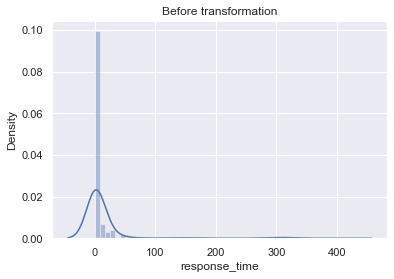

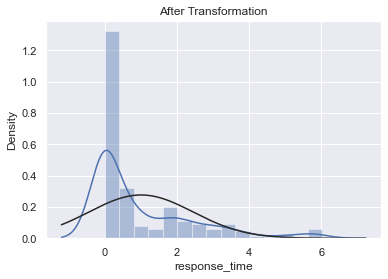

In [17]:
from scipy.stats import norm, skew
from scipy.special import boxcox1p

plt.title('Before transformation')
rt = df.response_time.dropna() + 1
sns.distplot(df.response_time)

plt.figure()
plt.title('After Transformation')
sns.distplot(rt.apply(np.log), fit=norm)

<AxesSubplot:title={'center':'After Transformation'}, xlabel='decision_time', ylabel='Density'>

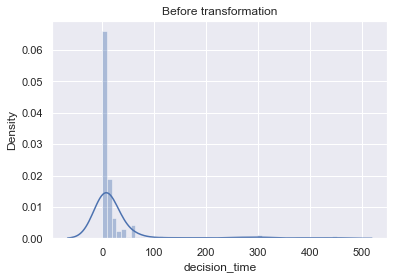

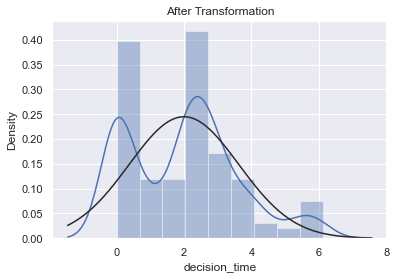

In [18]:
from scipy.stats import norm, skew
from scipy.special import boxcox1p

plt.title('Before transformation')
rt = df.decision_time.dropna() + 1
sns.distplot(df.decision_time)

plt.figure()
plt.title('After Transformation')
sns.distplot(rt.apply(np.log), fit=norm)

In [19]:
# df = df[['status_mapped', 'french_level', 'experience', 'response_time', 'decision_time']]

### Label encoding
Helps us predict on certain categories of data

In [20]:
# Split decision times into groups of 20 day periods
decision_time_splits = np.ceil(df['decision_time'].max() / 20).astype(int)
decision_map = pd.concat(
    pd.Series(str(i + 1), index=range(i * 20, 20 + i * 20)) 
    for i in range(decision_time_splits)
)

df['response_time'] = df['response_time'].map(decision_map)
df['decision_time'] = df['decision_time'].map(decision_map)

# Replace decision and reponse times by their log values
df['decision_time'] = df['decision_time'].astype(float).dropna().apply(np.log)
df['response_time'] = df['response_time'].astype(float).dropna().apply(np.log)

# Rename target/dependent variable
df.rename(index=str, columns={'status_mapped': 'y'}, inplace=True)

Encode (replace unique values by integers) experience and french level

In [21]:
le = LabelEncoder()

le.fit(df['experience'].unique())
df['experience'] = le.transform(df['experience'])

le.fit(df['french_level'].unique())
df['french_level'] = le.transform(df['french_level'])
df['french_level'].fillna('0', inplace=True)

Remove rows with null values

In [22]:
rt_nulls = df.response_time[df.response_time.isnull()].index
dt_nulls = df.decision_time[df.decision_time.isnull()].index
fl_nulls = df.french_level[df.french_level.isnull()].index

indices_to_drop = rt_nulls.union(dt_nulls).union(fl_nulls)
df.drop(indices_to_drop, inplace=True)

### Prepare for one hot encoding

In [23]:
xp_unique = df.experience.unique()
fl_unique = df.french_level.unique()
xp_unique, fl_unique

(array([3, 1, 2, 0]), array([1, 2, 4, 7, 3, 5, 6, 0]))

In [24]:
experience_map = dict((e, int(bool(e > max(xp_unique) / 2))) for e in xp_unique)
french_level_map = dict((f, int(bool(f + 1 > max(fl_unique) / 2))) for f in fl_unique)

In [25]:
sorted(experience_map.items()), sorted(french_level_map.items())

([(0, 0), (1, 0), (2, 1), (3, 1)],
 [(0, 0), (1, 0), (2, 0), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)])

In [26]:
df['experience'] = df['experience'].map(experience_map)
df['french_level'] = df['french_level'].map(experience_map)

### One hot encoding

In [27]:
for column in ('french_level', 'experience'):
    dummies = pd.get_dummies(df[column], prefix=f'_{column}')
    df = df.join(dummies, how='outer').drop([column], axis=1)

df = df[[
    'y', 
    'response_time', 
    'decision_time', 
    '_french_level_0.0', 
    '_french_level_1.0',
    '_experience_0',
    '_experience_1'
]]

In [28]:
y = df['y']
X = df.drop(['y', '_experience_0', '_french_level_0.0'], axis=1)

### Hold out & Cross validation

In [29]:
n_hold_out = 100
X, y = X[:-n_hold_out], y[:-n_hold_out]
X_cv, y_cv = X[:n_hold_out], y[:n_hold_out]

<AxesSubplot:>

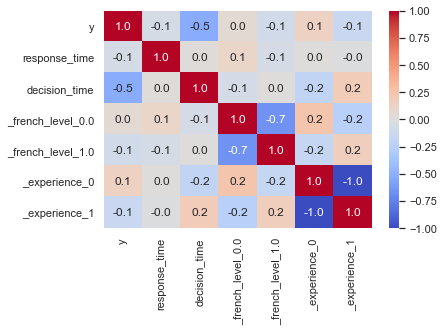

In [30]:
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.1f')

## Split, train and predict on test set

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model = XGBClassifier()
model.fit(X_train, y_train)

[13:40:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [32]:
y_pred = model.predict(X_test)

In [40]:
from pprint import pprint
pprint(classification_report(y_test, y_pred, output_dict=True))

{'0': {'f1-score': 0.6896551724137931,
       'precision': 0.9090909090909091,
       'recall': 0.5555555555555556,
       'support': 18},
 '1': {'f1-score': 0.9426751592356688,
       'precision': 0.9024390243902439,
       'recall': 0.9866666666666667,
       'support': 75},
 'accuracy': 0.9032258064516129,
 'macro avg': {'f1-score': 0.816165165824731,
               'precision': 0.9057649667405765,
               'recall': 0.7711111111111111,
               'support': 93},
 'weighted avg': {'f1-score': 0.8937035488830476,
                  'precision': 0.9037264859452113,
                  'recall': 0.9032258064516129,
                  'support': 93}}
